In [1]:
import os
import sys

import pickle

import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import sklearn.preprocessing as skp

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
import arch.unitroot as au
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
py.init_notebook_mode(connected=True)

/opt/anaconda3/envs/crypto-env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from TCC_pkg import dataanalysis as da
from TCC_pkg import testspecification as tspec

## Load data

In [3]:
series_name = 'coffee'
with open('../Data/{}.pkl'.format(series_name), 'rb') as f:
    df_raw = pickle.load(f)

## Initial summary of data

In [4]:
df = df_raw
print('Shape: {}\n'.format(df.shape))
print('Indices: \n{}\n{}\n'.format(df.index[:5], df.index[-5:]))
print('Columns: \n{}\n'.format(df.columns))
print('Describe(): \n{}\n'.format(df.describe()))

Shape: (1833, 2)

Indices: 
DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07',
               '2011-01-10'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2018-05-23', '2018-05-24', '2018-05-25', '2018-05-30',
               '2018-05-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

Columns: 
Index(['Close', 'Direction'], dtype='object')

Describe(): 
             Close    Direction
count  1833.000000  1832.000000
mean      1.579341    -0.039301
std       0.439494     0.999500
min       0.997100    -1.000000
25%       1.250700    -1.000000
50%       1.408300    -1.000000
75%       1.774600     1.000000
max       2.967500     1.000000



## Plot data

In [5]:
df = df_raw
da.plotscatter(df=df[['Close']], name='Coffee', title='Coffee Price')

# <span style='color:crimson'>2.</span> Preprocessing

## <span style='color:MediumBlue'>2.1.</span> Adjusting values

In [6]:
# Adjust time-series
df = df_raw

# 1. Find zeros or negative values
print('Number of zero-values: {}'.format(df[df==0].count().values))

# 2. Find NaNs
print('Number of NaNs: {}'.format(df[df.isna().values].count().values))

# 3. Eliminate entries with NaNs
df = df.dropna(how='any', axis=0)

# 4. Gaps
date_gaps = np.array([(df.index[i]-df.index[i-1]).days for i in range(1,len(df.index))])
print('Average gap: {}'.format(date_gaps.mean()))
print('Max gap: {}'.format(date_gaps.max()))
print('No. of gaps greater than 5: {}'.format(len(date_gaps[date_gaps>5])))
print('15 greatest gaps: {}'.format(np.sort(date_gaps)[-15:]))
print('Dates of greatest gap: \n{}\n'.format(df.iloc[date_gaps.argmax()-1:date_gaps.argmax()+3]))

df_adj = df

Number of zero-values: [0 0]
Number of NaNs: [1 0]
Average gap: 1.4762424904423812
Max gap: 13
No. of gaps greater than 5: 8
15 greatest gaps: [ 4  4  4  5  5  5  5  6  7  7 11 12 12 12 13]
Dates of greatest gap: 
             Close  Direction
Date                         
2014-12-22  1.6722        1.0
2014-12-23  1.6471       -1.0
2015-01-05  1.5408       -1.0
2015-01-06  1.6047        1.0



## <span style='color:MediumBlue'>2.2.</span> Visual analysis

### Outliers

In [7]:
df = df_adj
ts = df_adj['Close']
n_std = 3

df = pd.concat([df, da.roll_stats(ts=ts, window=30)], axis=1).dropna(how='any',axis=0)
df['Upper'] = df['Rolling Mean'] + n_std*df['Rolling Variance'].apply(np.sqrt)
df['Lower'] = df['Rolling Mean'] - n_std*df['Rolling Variance'].apply(np.sqrt)

da.plotscatter(df.drop(columns='Direction'))

# Outlier criterion
df_out = df[(df['Close'] > df['Upper']) | (df['Close'] < df['Lower'])]
df['Out'] = df.loc[df_out.index, 'Close']

df = df.replace(np.nan, 0) # for plotting
da.plotscatter(df.drop(columns='Direction'))

df = df.drop(df_out.index)
df_adj_noout = df[['Close']]

### Stationarity tests

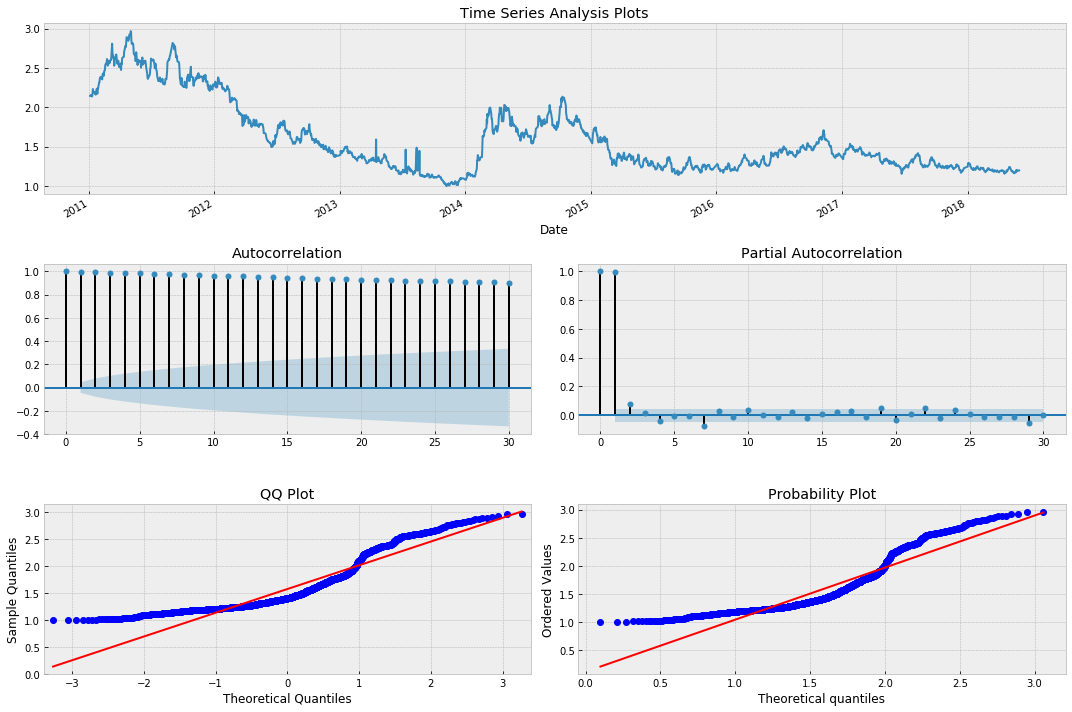

In [8]:
ts = df_adj['Close']

rolling_stats = da.roll_stats(ts=ts, window=30)
da.plotscatter(rolling_stats)
da.tsplot(ts, lags=30)

In [9]:
ts = df_adj['Close']

# Try to confirm stationarity
da.test_unitroot_adf(ts=ts)
da.test_unitroot_phillips_perron(ts=ts)

# Try to confirm unit-root
da.test_stationarity_kpss(ts=ts)

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.721
P-value                         0.421
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.696
P-value                         0.433
Lags                               25
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

    KPSS Stationarity Test Results   
Test Statistic                  3.563
P-value                         0.000
Lags                               2

## <span style='color:MediumBlue'>2.3.</span> Transformations

### <span style='color:Goldenrod'>2.3.1</span> Log-transform

In [10]:
df = df_adj[['Close']]

# Log-transform

df_log = pd.concat([df.applymap(np.log), df_adj[['Direction']]], axis=1)

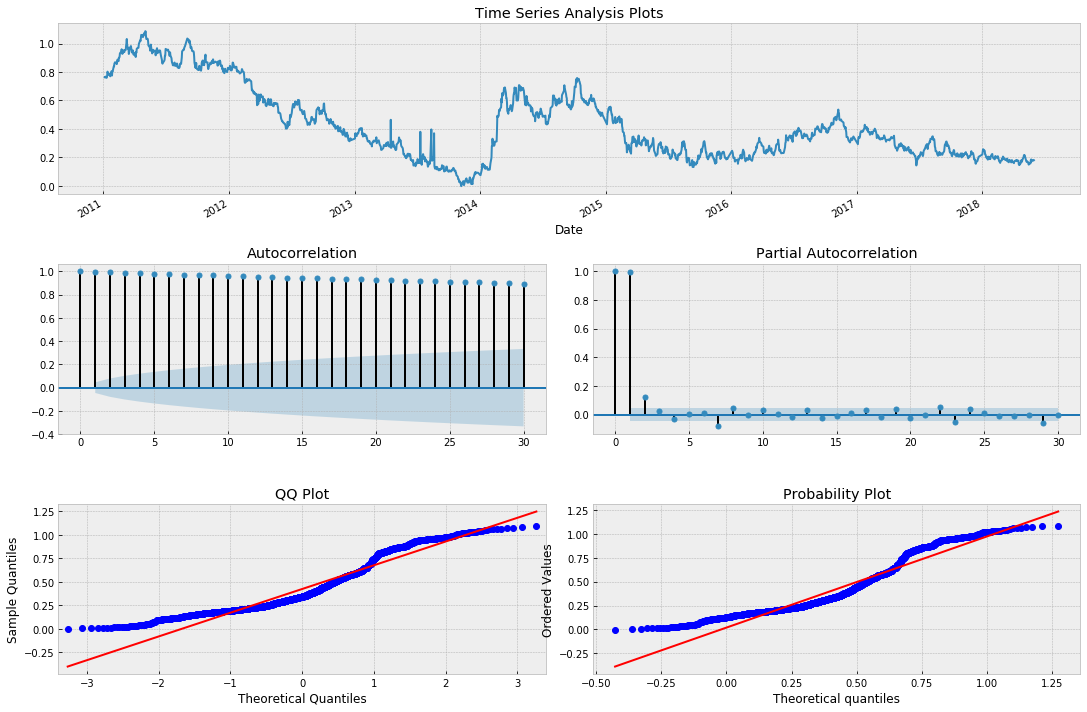

In [11]:
ts = df_log['Close']

rolling_stats = da.roll_stats(ts=ts, window=30)
da.plotscatter(rolling_stats)
da.tsplot(ts, lags=30)

In [12]:
ts = df_log['Close']

# Try to confirm stationarity
da.test_unitroot_adf(ts=ts)
da.test_unitroot_phillips_perron(ts=ts)

# Try to confirm unit-root
da.test_stationarity_kpss(ts=ts)

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.759
P-value                         0.401
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.748
P-value                         0.407
Lags                               25
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

    KPSS Stationarity Test Results   
Test Statistic                  3.419
P-value                         0.000
Lags                               2

### <span style='color:Goldenrod'>2.3.1</span> Differencing

In [13]:
df = df_log[['Close']]

df_log_diff = df_log.copy()
df_log_diff['Close'] = da.difference_ts(df=df)
df_log_diff = df_log_diff.dropna()

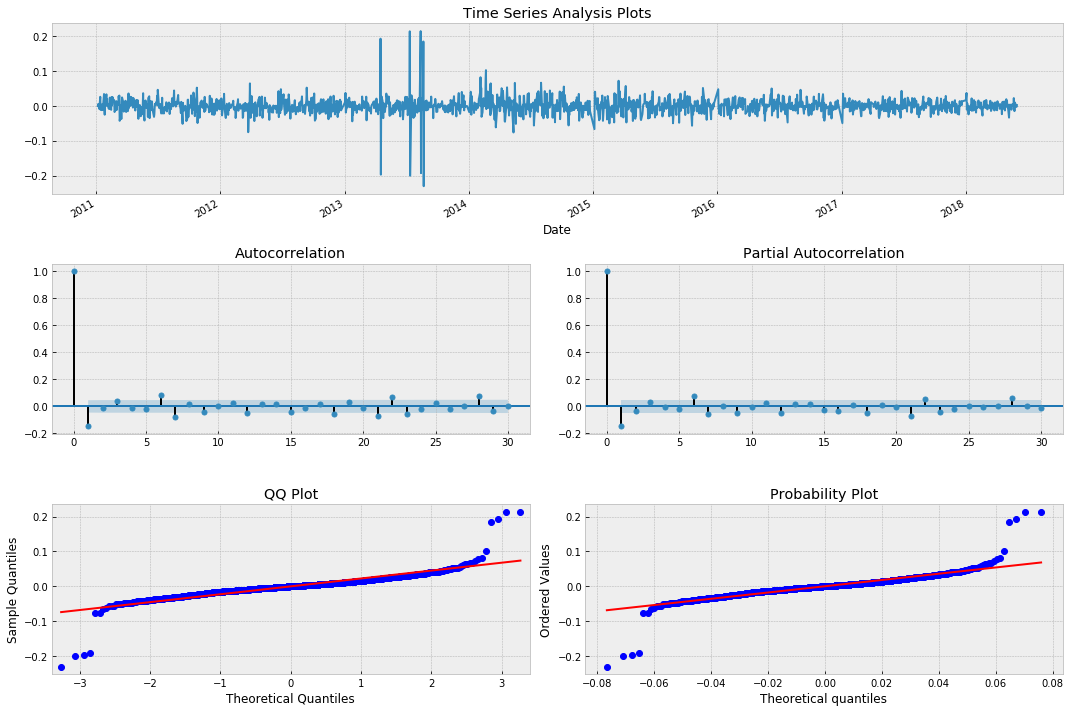

In [14]:
ts = df_log_diff['Close']

rolling_stats = da.roll_stats(ts=ts, window=30)
da.plotscatter(df_log_diff[['Close']])
da.tsplot(ts, lags=30)

In [15]:
ts = df_log_diff['Close']

# Try to confirm stationarity
da.test_unitroot_adf(ts=ts)
da.test_unitroot_phillips_perron(ts=ts)

# Try to confirm unit-root
da.test_stationarity_kpss(ts=ts)

   Augmented Dickey-Fuller Results   
Test Statistic                -10.152
P-value                         0.000
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

     Phillips-Perron Test (Z-tau)    
Test Statistic                -50.281
P-value                         0.000
Lags                               25
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

    KPSS Stationarity Test Results   
Test Statistic                  0.060
P-value                         0.816
Lags                               2

# <span style='color:crimson'>3.</span> Data fitting

In [16]:
# Defines the input
df_input = df_log_diff.copy()

In [17]:
diff_pred_func = lambda df: df.apply(np.sign)
classification_functions_dict = {'coffee':diff_pred_func}

In [18]:
def forecast_return_volatility(ts, mu=0, phi=[], theta=[], gmu=0, alpha=[], beta=[]):
    '''1-step ahead prediction for an ARMA-GARCH combination

       Input:
       ts    -- Pandas Series with time series
       mu    -- Mean of ARMA process           (default:  0)
       phi   -- AR coefficients of ARMA model  (default: [])
       theta -- MA coefficients of ARMA model  (default: [])
       gmu   -- Mean of GARCH process          (default:  0)
       alpha -- AR coefficients of GARCH model (default: [])
       beta  -- MA coefficients of GARCH model (default: [])
       
       Default model is white noise (ARMA(0,0) with mean 0). 
       The means, both of ARMA and GARCH, are considered to be 0.
       
       Output:
       pred -- Pandas DataFrame with 1-step ahead forecasted returns and volatility
    '''
    # Cardinalities
    n = len(ts.values) # number of samples
    p = len(phi)       # number of AR coefficients
    q = len(theta)     # number of MA coefficients
    m = len(alpha)     # number of GARCH-AR coefficients
    s = len(beta)      # number of GARCH-MA coefficients
    
    # Series (append zeros in beginning for convenience in loop)
    y = ts.values.reshape(n)
    r = np.zeros(shape=n)                     # array with returns
    a = np.zeros(shape=n)                     # array with shocks
    s2 = np.zeros(shape=n)                    # array with sigmas^2
    e = np.full(shape=n, fill_value=np.nan)   # array with eps = standardized shocks = residuals of GARCH
    
    # Loop over time horizon
    for t in range(n):
        # Predict return in time t
        AR  = np.inner(  phi[0:min(t,p)], np.flip(  y[max(0,t-p):t], axis=-1)).astype(float) # AR term
        MA  = np.inner(theta[0:min(t,q)], np.flip(  a[max(0,t-q):t], axis=-1)).astype(float) # MA term
        r[t] = mu + AR - MA     # add terms to get expected value of ARMA prediction
        a[t] = r[t] - y[t] # residual
        
        if len(alpha)>0 or len(beta)>0:
            # Evaluate volatility process
            gAR = np.inner(alpha[0:min(t,m)], np.flip(a[max(0,t-m):t]**2, axis=-1)).astype(float) # GARCH-AR term
            gMA = np.inner( beta[0:min(t,s)], np.flip(  s2[max(0,t-s):t], axis=-1)).astype(float) # GARCH-MA term
            s2[t] = gmu + gAR + gMA  # add terms to get volatility

            # Evaluate standardized shocks (residuals of GARCH process)
            assert s2[t]>=0.0
            e[t] = a[t]/np.sqrt(s2[t])
    
    # Create DataFrame with results
    matrx = np.concatenate((r.reshape(n,1),a.reshape(n,1),(a**2).reshape(n,1),s2.reshape(n,1),e.reshape(n,1)), axis=1)
    pred = pd.DataFrame(data=matrx, index=ts.index, 
                        columns=['Pred. Return','Shocks','Shocks^2','Volatility','Std Shocks'])
    return pred

In [19]:
def best_model_order(ts, p_rng, q_rng):
    ts = ts.dropna(axis=0,how='any')
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    
    # Some models raise an exception of dividing by NaN or 0
    np.seterr(divide='ignore', invalid='ignore')

    all_aic = np.full(shape=(max(p_rng)+1,max(q_rng)+1), fill_value=np.nan)
    for i in p_rng:
        for j in q_rng:
            if i is 0 and j is 0: continue
            try:
#                 tmp_mdl = sm.tsa.ARIMA(ts, order=(i,0,j)).fit(method='mle', trend='c', maxiter=300)
                tmp_mdl = sm.tsa.SARIMAX(ts, order=(i,0,j), trend='c', maxiter=300).fit(solver='lbfgs')
                tmp_aic = tmp_mdl.aic
                all_aic[i,j] = tmp_aic
                if tmp_aic < best_aic:
                    best_mdl = tmp_mdl
                    best_aic = tmp_aic
                    best_order = (i, 0, j)
            except: continue
    print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))
    if best_order is None:
        best_order = (1,0,0)
        best_mdl = sm.tsa.SARIMAX(ts, order=best_order, trend='c', maxiter=300).fit(solver='lbfgs')
        print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))
    return best_mdl, best_order, best_aic, all_aic

In [20]:
import warnings

def fit_and_predict(df_input, windows, h):

    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.filterwarnings(action='once')

    # Input and gets parameters
    ts_in = df_input['Close']
    mean_ts = ts_in.mean()
    std_ts = ts_in.std()

    # Standardizes to mean=0/var=1 and adds 1
    ts_in = (ts_in - mean_ts)/std_ts + 1

    # Create a DataFrame to store results
    windows = np.array(windows)
    mx = max(windows[windows<ts_in.shape[0]]) # largest window excluding the infinite one
    df = pd.DataFrame(columns=['{}'.format(w) for w in windows], index=ts_in.index[mx:])

    # for k in range(0,len(df.index),h):
    for k in range(mx, len(ts_in.index), h): # predict next h values
        print('\n\n',k)
        ts_test  = ts_in.iloc[k:k+h]
        for w in windows:
            print(w, end=': ')
            ts_train = ts_in.iloc[max(k-w,0):k]

            fitted_mdl, best_order, _, _ = best_model_order(ts_train, range(4), range(4))

            mdl_test = sm.tsa.SARIMAX(endog=ts_test, order=best_order, trend='c')
            mdl_test = mdl_test.filter(fitted_mdl.params)

            adj_values = (mdl_test.predict().values - 1)*std_ts + mean_ts
            df.loc[df.index[k-mx:k-mx+h], '{}'.format(w)] = adj_values

    return df

In [21]:
import operator

def execute_test_routine(series_name, df, test_spec, classification_func=None, windows=None, decay_array=None):
    # Fixed parameters
    h = 14 # prediction horizon

    # Parameters
    if windows is None:
        windows = [63, 126, 252, df.shape[0]] # past values to fit ARMA

    # Hyperparameters
    if decay_array is None:
        decay_array = (0.95, 0.98, 0.99, 0.995, 0.999)

    # PART 1: Fit models and make predictions (shortcut for the AR case specifically)
    # Load/predict classes using autoregressive models
    save_pred_path = './Predictions/{}.pkl'.format(series_name)
    try:
        with open(save_pred_path, 'rb') as f:
            df = pickle.load(f)
    except:
        # Prediction function
        df_out = fit_and_predict(df, windows, h)
        df_out.to_pickle(save_pred_path) # backup
        df_out = df_out.dropna()   
        df_out = classification_func(df_out)
        df = pd.concat([df, df_out], axis=1)
        df = df.dropna()  
        df.to_pickle(save_pred_path)
    
    # PART #2: Evaluate predictions
    # Model parameters
    ar_params = windows
    
    # First date of test sets
    start_dates = test_spec.start_dates

    # Initialize variables
    pred_arr = np.empty(0)
    real_arr = np.empty(0)
    for instance in test_spec.instance:
        decay_mcc = {}
        for decay in decay_array:
            decay_mcc[decay] = 0

            # For each forward validation index, get validation-set performance
            for ifv in range(len(instance.expanding_window_fv.train_sets)): # expanding window only
                train_ind = instance.expanding_window_fv.train_sets[ifv]

                # For each combination of parameters, evaluate their weighted-mcc
                params_mcc = {}
                for params in ar_params:
                    real = df.loc[:train_ind[-1], 'Direction'].values
                    pred = df.loc[:train_ind[-1],'{}'.format(params)].values
                    params_mcc[params] = da.mcc_weighted(real, pred, decay)

                # Apply best params to the validation set
                val_ind = instance.expanding_window_fv.val_sets[ifv]
                best_params = max(params_mcc.items(), key=operator.itemgetter(1))[0] 
                real = df.loc[val_ind, 'Direction'].values
                pred = df.loc[val_ind,'{}'.format(best_params)].values
                decay_mcc[decay] += da.mcc_weighted(real, pred, decay)

        # Decay that yielded maximum mcc
        best_decay = max(decay_mcc.items(), key=operator.itemgetter(1))[0] 
        print('Best decay: {}'.format(best_decay))

        # Use best_decay to select among parameters
        params_mcc = {}
        train_set = instance.train_set
        for params in ar_params:
            real = df.loc[:train_set[-1], 'Direction'].values
            pred = df.loc[:train_set[-1],'{}'.format(params)].values
            params_mcc[params] = da.mcc_weighted(real, pred, best_decay)
        best_params = max(params_mcc.items(), key=operator.itemgetter(1))[0]
        print('Best window: {}'.format(best_params))

        # Predict using parameters
        pred = df.loc[instance.test_set, '{}'.format(best_params)].values.astype(int)
        real = df.loc[instance.test_set,'Direction'].values.astype(int)
        pred_arr = np.r_[pred_arr, pred]
        real_arr = np.r_[real_arr, real]

    # Evaluate the entire test set together
    quality_metrics_dict = da.classification_metrics(y_true=real_arr, y_pred=pred_arr)
    
    return quality_metrics_dict

In [22]:
test_spec = tspec.TestSpec(indices=df_input.index, 
                     start_dates=['2016-01', '2016-07', '2017-01', '2017-07', '2018-01'], 
                     window_size=400
                    )


In [23]:
ar_res = {}
ar_res['ARMA'] = execute_test_routine(series_name,
                                      df_input, 
                                      test_spec,
                                      classification_functions_dict['{}'.format(series_name)]
                                     )
autoregressive_results = pd.DataFrame(data=ar_res)
autoregressive_results

Best decay: 0.99
Best window: 63
Best decay: 0.995
Best window: 63
Best decay: 0.98
Best window: 126
Best decay: 0.95
Best window: 126
Best decay: 0.995
Best window: 126


,ARMA
accuracy,0.500846
cohen_kappa,0.001546
f1,0.492255
fbeta,0.492255
fn,151.000000
fp,144.000000
mathews_corrcoef,0.001547
precision,0.498258
recall,0.486395
tn,153.000000


In [24]:
save_pred_path = './Predictions/{}.pkl'.format(series_name)
with open(save_pred_path, 'rb') as f:
    df = pickle.load(f)
    
df

,Close,Direction,63,126,252,1831
Date,,,,,,
2012-01-09,-0.000666,-1.0,1,-1,1,1
2012-01-10,0.006021,1.0,1,-1,1,1
2012-01-11,0.014156,1.0,-1,-1,1,1
2012-01-12,0.034685,1.0,-1,-1,1,1
2012-01-13,-0.000757,-1.0,-1,1,1,1
2012-01-17,-0.034798,-1.0,-1,-1,-1,-1
2012-01-18,0.000218,1.0,-1,1,-1,-1
2012-01-19,-0.000523,-1.0,1,1,1,1
2012-01-20,0.006081,1.0,1,-1,1,1


## <span style='color:MediumBlue'>3.1.</span> ARMA model selection

### <span style='color:Goldenrod'>3.1.1</span> Pre-select with AIC

## <span style='color:MediumBlue'>3.2.</span> Fitting and refinement

### <span style='color:Goldenrod'>3.1.2</span> Confidence/significance refinement

### <span style='color:Goldenrod'>3.1.3</span> Final selection with Validation Set

## <span style='color:MediumBlue'>3.3.</span> Residual Analysis

### <span style='color:Goldenrod'>3.3.1</span> ARCH effects

### <span style='color:Goldenrod'>3.3.2</span> Serial correlation of residuals

## <span style='color:MediumBlue'>3.4.</span> GARCH model selection

## <span style='color:MediumBlue'>3.5.</span> Fitting

## <span style='color:MediumBlue'>3.6.</span> Standardized Residual Analysis

### <span style='color:Goldenrod'>3.6.1</span> Serial correlation of residuals

# <span style='color:crimson'>4.</span> Testing: One-step-ahead Forecasting

## <span style='color:MediumBlue'>3.1.</span> Iterative

## <span style='color:MediumBlue'>3.1.</span> Daily remodeling

O que precisa ter:
- janela de tempo - quantos dias consideraremos para o modelo?
    - isso pode ser feito utilizando todo o dataset com intervalos randomicos
- 'stride' - saltos de quantos dias ate novo modelo?
    - tambem pode ser estimado com todo o dataset e intervalos randomicos
- Funcoes
    - Tirar log
    - Diferenciar
    - Testes estatisticos
    - Encontrar melhor modelo
    - Predizer (1 dia a frente ou varios)